<a href="https://colab.research.google.com/github/IuliaDuta/ASD.github.io/blob/master/Daniel_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Daniel McFadyen Machine Learning Assignment 1#

We begin by doing the boring but necessary job of importing everything we need to complete the assignment. 

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from typing import Iterator, List, Callable, Tuple
import torch
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

**Importing the data**

We were instructed to import the data in some fancy way, but the way I am doing it works, if I can be bothered I will do it correctly.

In [2]:
from google.colab import files
upload = files.upload()

Saving pmi-data.csv to pmi-data.csv


In [4]:
data = pd.read_csv("pmi-data.csv", index_col=0) #dropping a pointless column at the start

In [5]:
data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,2,67.0,0,1,1,4,0,228.69,36.6,1,1
1,51676,1,61.0,0,0,1,3,1,202.21,29.1,2,1
2,31112,2,80.0,0,1,1,4,1,105.92,32.5,2,1
3,60182,1,49.0,0,0,1,4,0,171.23,34.4,0,1
4,1665,1,79.0,1,0,1,3,1,174.12,24.0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5102,45010,1,57.0,0,0,1,4,1,77.93,21.7,2,0
5105,18234,1,80.0,1,0,1,4,0,83.75,29.1,2,0
5106,44873,1,81.0,0,0,1,3,0,125.20,40.0,2,0
5107,19723,1,35.0,0,0,1,3,1,82.99,30.6,2,0


Although we were told to leave the data untouched, it is clear that we need to remove the first column, namely __id__ column. 

In [6]:
data=data.drop(["id"],axis=1)

We now split our data into our features matrix $X$ and our labels $y$.

In [7]:
X = data.drop(["stroke"], axis=1)
y = data['stroke']

Now we split our data into data for training the model and data for validating the model. We have chosen to first shuffle the data, we don't know how the data was given to us. 

We choose to have 20% of our data for validation, this gives us both a large enough data set to train the model while gives us a large enough validation set to properly evaluate the model. 

_Throughout I have interchanged the use of the word validate and test, since we are not optimising our model, the name we give them doesn't matter, we are merely using it to evaluate our model and to see under/overfitting_.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True) #splitting data into test and train.

## turning our data into numpy arrays
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()


Now we are going to create a __Dataset__ which displays the features and the associated label in the following format $$[X[i,:], y[i]]$$ for both the training and validations data.

We then feed this through a __train_dataloader()__ which will split the validation and training dataset into batches.  

In [9]:
class StrokeDataset(Dataset): 

  ## A class which will return a dataset
  def __init__(self, X, y): 
    self.X = X
    self.y = y

  def __getitem__(self, index):
    
    ##concatenting the labels and features as mentioned in previous text cell
    label=self.y[index]
    features = self.X[index,:]
    sample = features, label
    return sample

  def __len__(self): 
    ##returns how many data points are in our dataset
    return len(self.y)

In [10]:
##Create an instance of our dataset for both test and train model
train_dataset=StrokeDataset(X_train, y_train)
test_dataset=StrokeDataset(X_test, y_test)

In [11]:
BATCH_SIZE=16
##Creating batches of size BATCH_SIZE for both our training and test data
train_dataloader = DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True  #shuffle the batches between each epoch [iulia]: SHUFFLE DATA!!
) 

validation_dataloader = DataLoader(
    dataset=test_dataset, 
    batch_size=BATCH_SIZE
)

###Creating a model### 

Now that we have manipulated our data appropriately, we are ready to create our model. We are going to use a neural network with 3 hidden layers which will output a scaler for each data point (this is to appease the loss function we will be using). Between each layer we will be using __relu__ between each layer.

In [12]:
class StrokeClassifier(nn.Module): 

    def __init__(self, 
                 hidden_size_1: int, 
                 hidden_size_2: int,
                 hidden_size_3 :int,
                 activation_fn: Callable):
        super().__init__()
        self.hidden_size_1 = hidden_size_1
        self.hidden_size_2 = hidden_size_2
        self.hidden_size_3 = hidden_size_3    
        
        self.layer_1 = nn.Linear(in_features = 10, out_features = self.hidden_size_1, bias=True)
        self.layer_2 = nn.Linear(in_features = self.hidden_size_1, out_features = self.hidden_size_2, bias=True)
        self.layer_3 = nn.Linear(in_features = self.hidden_size_2, out_features = self.hidden_size_3, bias=True)
        self.output_layer = nn.Linear(in_features = self.hidden_size_3, out_features = 1, bias = True)    
    
        self.activation_fn = activation_fn    
    
    def forward(self, x):
        # TODO: layer1 + activation
        h1 = self.activation_fn(self.layer_1(x))
        
        # TODO: layer2 + activation
        h2 = self.activation_fn(self.layer_2(h1))        
        
        h3= self.activation_fn(self.layer_3(h2))
        
        # TODO: output layer
        out = self.output_layer(h3)        
        
        return out

We will now define our loss function. We have been instructed to use __BCEWithLogitsLoss()__, which takes as input a vector with the same shape as the labels. Later we will use the __max_weight__ input of the loss function, we will calculate everything we need now.

In [13]:
n, k=len(train_dataset), np.count_nonzero(y_train)
weight=torch.ones([1])
weight[0] = (n-k)/k #number of 0 labels divided by 1 labels eg: how many more 0's do we have than 1's?

loss_crt = nn.BCEWithLogitsLoss()#pos_weight = weight)

We now want a way to see how our model is doing on our test data, so we will now train and evaluate our model at each prediction.

In [14]:
def train_epoch(model, train_dataloader, loss_crt, optimizer, device): 
  model.train() 
  epoch_loss = 0.0
  num_batches = len(train_dataloader)
  predictions = [] #where we will add the predictions
  labels = [] #where we will store the true labels

  for idx, batch in tqdm(enumerate(train_dataloader)): 
    batch_features, batch_labels = batch #extract features and labels from dataloader

    batch_features = batch_features.to(device) #send our data to device
    batch_labels = batch_labels.to(device).squeeze() #likewise and squeze to transform into vector of length 16 opposed to 16x1 matrix
    

    output = model(batch_features.float()).squeeze() #run our data through our model? yes
    
    output_probs = torch.sigmoid(output) #transform the output into range 0-1
    batch_predictions = torch.round(output_probs) #if >0.5 then it predicts a score of 1 (stroke)

    predictions += batch_predictions.tolist() #update the lists
    labels += batch_labels.tolist()


    loss= loss_crt(output.to(torch.float64), batch_labels.to(torch.float64)) #calculate error from out model
    loss_scalar = loss.item() #turn the loss output into a scaler
    loss.backward() #propogate backwards through loss function

    optimizer.step() #optimise our parameters

    model.zero_grad() #reset the gradients

    epoch_loss += loss_scalar #add it to our loss for this epoch

  train_epoch_loss = epoch_loss/num_batches #average loss over a batch in this epoch
  return train_epoch_loss, predictions, labels


def eval_epoch(model, validation_dataloader, loss_crt, device): 

  model.eval() 
  epoch_loss=0.0
  num_batches = len(validation_dataloader)
  predictions = []
  labels = []
  with torch.no_grad(): #we have no interest in computing gradients now
    for idx, batch in tqdm(enumerate(validation_dataloader)): #enumerates over dataloader
      batch_features, batch_labels = batch #as above

      batch_features = batch_features.to(device) #as above
      batch_labels = batch_labels.to(device).squeeze() #as above

      output = model(batch_features.float()).squeeze() #as above
      
      
      output_probs = torch.sigmoid(output) #as above
      batch_predictions = torch.round(output_probs) #as above

      predictions += batch_predictions.tolist() #as above
      labels += batch_labels.tolist() #as above

      loss= loss_crt(output.to(torch.float64), batch_labels.to(torch.float64)) #as above
      loss_scalar = loss.item() #as above
      epoch_loss+= loss_scalar#as above
  val_epoch_loss = epoch_loss/num_batches#as above
  return val_epoch_loss, predictions, labels

Bcecause this is a classification problem (currently) we will seek to compute metrics such as accuracy and also to look at the confusion matrix. So we will import functions that will help us do that now. 

In [15]:
def compute_accuracy(predictions: List[int], labels:List[int]):
    
    correct_predictions = 0
    n=len(predictions) #number of predictions made in total
    for i in range (n): 
      if predictions[i]==labels[i]: 
        correct_predictions+=1 ##counting number of correct predictions

    epoch_accuracy = correct_predictions/n #correct/total
    return epoch_accuracy

def compute_confusion_matrix(predictions: List[int], labels:List[int]):
    
    correct_no_stroke = 0
    correct_stroke = 0
    wrong_no_stroke = 0
    wrong_stroke = 0

    n=len(predictions) #number of predictions made
    for i in range (n): 
      if predictions[i] == labels[i]: 
        if predictions[i]==1:  
          correct_stroke+=1
        else: 
          correct_no_stroke+=1
      else: 
        if predictions[i]==1: 
          wrong_stroke+=1
        else: 
          wrong_no_stroke+=1 
      

    return (correct_no_stroke, wrong_no_stroke, correct_stroke, wrong_stroke)

Now we are ready to give our model some hyperparameters and look at the accuracy and loss plots.

In [16]:
hyperparams = {
    'lr': 0.001,
    'num_epochs': 100,
    'hidden_size_1': 64,
    'hidden_size_2': 32,
    'hidden_size_3':16,
    'activation_fn': nn.ReLU(),
} #setting up our hyperparameters which we will feed in to our model and at some point hopefully optimize!
device = torch.device('cuda') 
model = StrokeClassifier(
    hidden_size_1=hyperparams['hidden_size_1'],
    hidden_size_2=hyperparams['hidden_size_2'],
    hidden_size_3=hyperparams['hidden_size_3'],
    activation_fn=hyperparams['activation_fn']
)
model.to(device) #move our model to gpu
optimizer = torch.optim.Adam( ##We shall pick Adam as our optimiser as Iulia says it funny :()
    params = model.parameters(), 
    lr = hyperparams['lr'])

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_acc = 0.0 ##for early stopping criteria but were just trying to have fun...

for epoch_idx in range(hyperparams['num_epochs']):
    train_epoch_loss, train_predictions, train_labels = train_epoch(
        model, 
        train_dataloader, 
        loss_crt, 
        optimizer,
        device
    )
    val_epoch_loss, val_predictions, val_labels = eval_epoch(
        model,
        validation_dataloader,
        loss_crt,
        device
    )
    train_acc = compute_accuracy(train_predictions, train_labels)
    val_acc = compute_accuracy(val_predictions, val_labels)
    train_losses.append(train_epoch_loss)
    val_losses.append(val_epoch_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print("epoch %d, train loss=%f, train acc=%f, val loss=%f, val acc=%f" % (
        epoch_idx, 
        train_epoch_loss,
        train_acc,
        val_epoch_loss,
        val_acc
    ))

    # early stopping
    # if val_acc >= best_val_acc:
    #     best_val_acc = val_acc
    # else:
    #     break


179it [00:03, 51.68it/s] 
45it [00:00, 1502.64it/s]


epoch 0, train loss=0.247719, train acc=0.941795, val loss=0.186893, val acc=0.949580


179it [00:00, 428.82it/s]
45it [00:00, 1407.43it/s]


epoch 1, train loss=0.226733, train acc=0.938990, val loss=0.187165, val acc=0.949580


179it [00:00, 433.46it/s]
45it [00:00, 1524.60it/s]


epoch 2, train loss=0.218424, train acc=0.939341, val loss=0.188321, val acc=0.949580


179it [00:00, 424.25it/s]
45it [00:00, 1371.57it/s]


epoch 3, train loss=0.212273, train acc=0.941795, val loss=0.189332, val acc=0.949580


179it [00:00, 416.32it/s]
45it [00:00, 1263.08it/s]


epoch 4, train loss=0.211932, train acc=0.939691, val loss=0.197735, val acc=0.949580


179it [00:00, 448.79it/s]
45it [00:00, 1474.04it/s]


epoch 5, train loss=0.210048, train acc=0.942146, val loss=0.175725, val acc=0.949580


179it [00:00, 444.21it/s]
45it [00:00, 1423.84it/s]


epoch 6, train loss=0.209737, train acc=0.940743, val loss=0.174918, val acc=0.949580


179it [00:00, 416.90it/s]
45it [00:00, 1145.12it/s]


epoch 7, train loss=0.203639, train acc=0.941795, val loss=0.186396, val acc=0.949580


179it [00:00, 424.90it/s]
45it [00:00, 1383.76it/s]


epoch 8, train loss=0.211769, train acc=0.941795, val loss=0.182249, val acc=0.949580


179it [00:00, 432.72it/s]
45it [00:00, 1357.72it/s]


epoch 9, train loss=0.206180, train acc=0.941795, val loss=0.176568, val acc=0.949580


179it [00:00, 432.83it/s]
45it [00:00, 1351.04it/s]


epoch 10, train loss=0.203757, train acc=0.941795, val loss=0.175170, val acc=0.949580


179it [00:00, 448.10it/s]
45it [00:00, 1426.20it/s]


epoch 11, train loss=0.200310, train acc=0.941795, val loss=0.174025, val acc=0.949580


179it [00:00, 439.95it/s]
45it [00:00, 1381.24it/s]


epoch 12, train loss=0.196907, train acc=0.941795, val loss=0.174918, val acc=0.949580


179it [00:00, 439.39it/s]
45it [00:00, 1371.13it/s]


epoch 13, train loss=0.202742, train acc=0.941795, val loss=0.171927, val acc=0.949580


179it [00:00, 434.56it/s]
45it [00:00, 1533.63it/s]


epoch 14, train loss=0.195943, train acc=0.941795, val loss=0.170367, val acc=0.949580


179it [00:00, 440.95it/s]
45it [00:00, 1446.78it/s]


epoch 15, train loss=0.201293, train acc=0.941795, val loss=0.176217, val acc=0.949580


179it [00:00, 439.07it/s]
45it [00:00, 1502.64it/s]


epoch 16, train loss=0.197827, train acc=0.941795, val loss=0.171847, val acc=0.949580


179it [00:00, 437.81it/s]
45it [00:00, 1400.10it/s]


epoch 17, train loss=0.196068, train acc=0.941795, val loss=0.173976, val acc=0.949580


179it [00:00, 430.80it/s]
45it [00:00, 1166.73it/s]


epoch 18, train loss=0.195718, train acc=0.941795, val loss=0.172186, val acc=0.949580


179it [00:00, 416.81it/s]
45it [00:00, 1363.37it/s]


epoch 19, train loss=0.196474, train acc=0.941795, val loss=0.169397, val acc=0.949580


179it [00:00, 446.99it/s]
45it [00:00, 1475.67it/s]


epoch 20, train loss=0.194558, train acc=0.941795, val loss=0.170634, val acc=0.949580


179it [00:00, 441.95it/s]
45it [00:00, 1248.69it/s]


epoch 21, train loss=0.197847, train acc=0.941795, val loss=0.174847, val acc=0.949580


179it [00:00, 446.67it/s]
45it [00:00, 1428.82it/s]


epoch 22, train loss=0.196162, train acc=0.941795, val loss=0.171654, val acc=0.949580


179it [00:00, 432.73it/s]
45it [00:00, 1418.47it/s]


epoch 23, train loss=0.190607, train acc=0.941795, val loss=0.173682, val acc=0.949580


179it [00:00, 444.32it/s]
45it [00:00, 1478.93it/s]


epoch 24, train loss=0.191678, train acc=0.941795, val loss=0.172904, val acc=0.949580


179it [00:00, 449.00it/s]
45it [00:00, 1474.18it/s]


epoch 25, train loss=0.190390, train acc=0.941795, val loss=0.177484, val acc=0.949580


179it [00:00, 437.08it/s]
45it [00:00, 1420.29it/s]


epoch 26, train loss=0.191675, train acc=0.941795, val loss=0.177140, val acc=0.949580


179it [00:00, 433.77it/s]
45it [00:00, 1371.43it/s]


epoch 27, train loss=0.191441, train acc=0.941795, val loss=0.167147, val acc=0.949580


179it [00:00, 434.76it/s]
45it [00:00, 1471.03it/s]


epoch 28, train loss=0.190420, train acc=0.941795, val loss=0.189152, val acc=0.949580


179it [00:00, 418.75it/s]
45it [00:00, 1278.92it/s]


epoch 29, train loss=0.191625, train acc=0.941795, val loss=0.174739, val acc=0.949580


179it [00:00, 425.63it/s]
45it [00:00, 1343.26it/s]


epoch 30, train loss=0.191754, train acc=0.941795, val loss=0.184700, val acc=0.949580


179it [00:00, 442.05it/s]
45it [00:00, 1396.76it/s]


epoch 31, train loss=0.188476, train acc=0.941795, val loss=0.166701, val acc=0.949580


179it [00:00, 429.41it/s]
45it [00:00, 1376.41it/s]


epoch 32, train loss=0.188423, train acc=0.941795, val loss=0.180552, val acc=0.949580


179it [00:00, 447.33it/s]
45it [00:00, 1496.96it/s]


epoch 33, train loss=0.193496, train acc=0.941795, val loss=0.175598, val acc=0.949580


179it [00:00, 429.30it/s]
45it [00:00, 1344.93it/s]


epoch 34, train loss=0.189209, train acc=0.941795, val loss=0.173173, val acc=0.949580


179it [00:00, 438.60it/s]
45it [00:00, 1159.82it/s]


epoch 35, train loss=0.190334, train acc=0.941795, val loss=0.167910, val acc=0.949580


179it [00:00, 411.97it/s]
45it [00:00, 1372.14it/s]


epoch 36, train loss=0.188433, train acc=0.941795, val loss=0.168684, val acc=0.949580


179it [00:00, 446.66it/s]
45it [00:00, 1423.37it/s]


epoch 37, train loss=0.190365, train acc=0.941795, val loss=0.168419, val acc=0.949580


179it [00:00, 436.86it/s]
45it [00:00, 1488.87it/s]


epoch 38, train loss=0.190467, train acc=0.941795, val loss=0.176006, val acc=0.949580


179it [00:00, 450.58it/s]
45it [00:00, 1359.58it/s]


epoch 39, train loss=0.188732, train acc=0.941795, val loss=0.168808, val acc=0.949580


179it [00:00, 446.66it/s]
45it [00:00, 1484.67it/s]


epoch 40, train loss=0.192613, train acc=0.941795, val loss=0.168572, val acc=0.949580


179it [00:00, 427.64it/s]
45it [00:00, 1300.74it/s]


epoch 41, train loss=0.192537, train acc=0.941795, val loss=0.169371, val acc=0.949580


179it [00:00, 428.74it/s]
45it [00:00, 1107.23it/s]


epoch 42, train loss=0.187753, train acc=0.941795, val loss=0.171170, val acc=0.949580


179it [00:00, 429.83it/s]
45it [00:00, 1254.87it/s]


epoch 43, train loss=0.186032, train acc=0.941795, val loss=0.171371, val acc=0.949580


179it [00:00, 440.70it/s]
45it [00:00, 1261.74it/s]


epoch 44, train loss=0.187913, train acc=0.941795, val loss=0.171691, val acc=0.949580


179it [00:00, 426.39it/s]
45it [00:00, 1331.50it/s]


epoch 45, train loss=0.189592, train acc=0.941795, val loss=0.173111, val acc=0.949580


179it [00:00, 435.75it/s]
45it [00:00, 1599.14it/s]


epoch 46, train loss=0.186769, train acc=0.941795, val loss=0.172927, val acc=0.949580


179it [00:00, 432.85it/s]
45it [00:00, 1476.80it/s]


epoch 47, train loss=0.185644, train acc=0.941795, val loss=0.169933, val acc=0.949580


179it [00:00, 433.21it/s]
45it [00:00, 1391.99it/s]


epoch 48, train loss=0.187754, train acc=0.941795, val loss=0.169702, val acc=0.949580


179it [00:00, 434.95it/s]
45it [00:00, 1460.65it/s]


epoch 49, train loss=0.185509, train acc=0.941795, val loss=0.172429, val acc=0.949580


179it [00:00, 451.61it/s]
45it [00:00, 1462.26it/s]


epoch 50, train loss=0.185663, train acc=0.941795, val loss=0.170051, val acc=0.949580


179it [00:00, 436.22it/s]
45it [00:00, 1402.81it/s]


epoch 51, train loss=0.185285, train acc=0.941795, val loss=0.168787, val acc=0.949580


179it [00:00, 429.90it/s]
45it [00:00, 1347.42it/s]


epoch 52, train loss=0.185047, train acc=0.941795, val loss=0.170240, val acc=0.949580


179it [00:00, 434.86it/s]
45it [00:00, 1251.86it/s]


epoch 53, train loss=0.185234, train acc=0.941795, val loss=0.169406, val acc=0.949580


179it [00:00, 429.26it/s]
45it [00:00, 1280.80it/s]


epoch 54, train loss=0.190369, train acc=0.941795, val loss=0.170504, val acc=0.949580


179it [00:00, 442.95it/s]
45it [00:00, 1189.65it/s]


epoch 55, train loss=0.187428, train acc=0.941795, val loss=0.172409, val acc=0.949580


179it [00:00, 398.82it/s]
45it [00:00, 1487.83it/s]


epoch 56, train loss=0.184992, train acc=0.941795, val loss=0.169098, val acc=0.949580


179it [00:00, 419.61it/s]
45it [00:00, 1351.24it/s]


epoch 57, train loss=0.184512, train acc=0.941795, val loss=0.168023, val acc=0.949580


179it [00:00, 424.04it/s]
45it [00:00, 1196.14it/s]


epoch 58, train loss=0.185479, train acc=0.941795, val loss=0.170955, val acc=0.949580


179it [00:00, 437.67it/s]
45it [00:00, 1347.16it/s]


epoch 59, train loss=0.183331, train acc=0.941795, val loss=0.173630, val acc=0.949580


179it [00:00, 434.11it/s]
45it [00:00, 1307.57it/s]


epoch 60, train loss=0.186022, train acc=0.941795, val loss=0.171227, val acc=0.949580


179it [00:00, 431.66it/s]
45it [00:00, 1378.48it/s]


epoch 61, train loss=0.186540, train acc=0.941795, val loss=0.168521, val acc=0.949580


179it [00:00, 436.65it/s]
45it [00:00, 1258.06it/s]


epoch 62, train loss=0.188101, train acc=0.941795, val loss=0.174913, val acc=0.949580


179it [00:00, 444.45it/s]
45it [00:00, 1327.79it/s]


epoch 63, train loss=0.186915, train acc=0.941795, val loss=0.172165, val acc=0.949580


179it [00:00, 447.25it/s]
45it [00:00, 1545.18it/s]


epoch 64, train loss=0.185122, train acc=0.941795, val loss=0.168413, val acc=0.949580


179it [00:00, 450.37it/s]
45it [00:00, 1487.39it/s]


epoch 65, train loss=0.183301, train acc=0.941795, val loss=0.168831, val acc=0.949580


179it [00:00, 418.88it/s]
45it [00:00, 1325.14it/s]


epoch 66, train loss=0.183980, train acc=0.941795, val loss=0.167981, val acc=0.949580


179it [00:00, 422.03it/s]
45it [00:00, 1284.01it/s]


epoch 67, train loss=0.185823, train acc=0.941795, val loss=0.167648, val acc=0.949580


179it [00:00, 419.67it/s]
45it [00:00, 1082.75it/s]


epoch 68, train loss=0.188951, train acc=0.941795, val loss=0.166179, val acc=0.949580


179it [00:00, 427.56it/s]
45it [00:00, 1222.77it/s]


epoch 69, train loss=0.181730, train acc=0.941795, val loss=0.172915, val acc=0.949580


179it [00:00, 404.66it/s]
45it [00:00, 1279.25it/s]


epoch 70, train loss=0.182821, train acc=0.941795, val loss=0.175694, val acc=0.949580


179it [00:00, 379.26it/s]
45it [00:00, 1285.35it/s]


epoch 71, train loss=0.183323, train acc=0.941795, val loss=0.169262, val acc=0.949580


179it [00:00, 423.85it/s]
45it [00:00, 1230.25it/s]


epoch 72, train loss=0.184675, train acc=0.941795, val loss=0.167135, val acc=0.949580


179it [00:00, 405.38it/s]
45it [00:00, 1249.65it/s]


epoch 73, train loss=0.182611, train acc=0.941795, val loss=0.171185, val acc=0.949580


179it [00:00, 410.84it/s]
45it [00:00, 1283.46it/s]


epoch 74, train loss=0.181172, train acc=0.941795, val loss=0.178036, val acc=0.949580


179it [00:00, 431.27it/s]
45it [00:00, 1192.06it/s]


epoch 75, train loss=0.181515, train acc=0.941795, val loss=0.169052, val acc=0.949580


179it [00:00, 444.91it/s]
45it [00:00, 1437.97it/s]


epoch 76, train loss=0.183630, train acc=0.941795, val loss=0.168962, val acc=0.949580


179it [00:00, 425.34it/s]
45it [00:00, 1341.84it/s]


epoch 77, train loss=0.184217, train acc=0.941795, val loss=0.170615, val acc=0.949580


179it [00:00, 431.74it/s]
45it [00:00, 1487.59it/s]


epoch 78, train loss=0.183223, train acc=0.941795, val loss=0.172797, val acc=0.949580


179it [00:00, 438.68it/s]
45it [00:00, 1460.23it/s]


epoch 79, train loss=0.183806, train acc=0.941795, val loss=0.174407, val acc=0.949580


179it [00:00, 453.62it/s]
45it [00:00, 1411.89it/s]


epoch 80, train loss=0.184235, train acc=0.941795, val loss=0.169055, val acc=0.949580


179it [00:00, 427.69it/s]
45it [00:00, 1271.76it/s]


epoch 81, train loss=0.183733, train acc=0.941795, val loss=0.166451, val acc=0.949580


179it [00:00, 447.35it/s]
45it [00:00, 1477.56it/s]


epoch 82, train loss=0.185603, train acc=0.941795, val loss=0.170602, val acc=0.949580


179it [00:00, 434.82it/s]
45it [00:00, 1467.54it/s]


epoch 83, train loss=0.181895, train acc=0.941795, val loss=0.170017, val acc=0.949580


179it [00:00, 431.60it/s]
45it [00:00, 1250.60it/s]


epoch 84, train loss=0.180975, train acc=0.941795, val loss=0.173024, val acc=0.949580


179it [00:00, 417.36it/s]
45it [00:00, 1230.99it/s]


epoch 85, train loss=0.184468, train acc=0.941795, val loss=0.169242, val acc=0.949580


179it [00:00, 418.60it/s]
45it [00:00, 1190.64it/s]


epoch 86, train loss=0.182359, train acc=0.941795, val loss=0.168918, val acc=0.949580


179it [00:00, 436.46it/s]
45it [00:00, 1556.37it/s]


epoch 87, train loss=0.181517, train acc=0.941795, val loss=0.167774, val acc=0.949580


179it [00:00, 435.98it/s]
45it [00:00, 1263.70it/s]


epoch 88, train loss=0.182922, train acc=0.941795, val loss=0.171288, val acc=0.949580


179it [00:00, 437.98it/s]
45it [00:00, 1489.85it/s]


epoch 89, train loss=0.179991, train acc=0.941795, val loss=0.170847, val acc=0.949580


179it [00:00, 415.11it/s]
45it [00:00, 1270.47it/s]


epoch 90, train loss=0.181233, train acc=0.941795, val loss=0.169807, val acc=0.949580


179it [00:00, 442.02it/s]
45it [00:00, 1313.06it/s]


epoch 91, train loss=0.181792, train acc=0.941795, val loss=0.169373, val acc=0.949580


179it [00:00, 419.08it/s]
45it [00:00, 1438.30it/s]


epoch 92, train loss=0.180376, train acc=0.941795, val loss=0.167446, val acc=0.949580


179it [00:00, 443.81it/s]
45it [00:00, 1430.98it/s]


epoch 93, train loss=0.180917, train acc=0.941795, val loss=0.171554, val acc=0.949580


179it [00:00, 414.61it/s]
45it [00:00, 1334.48it/s]


epoch 94, train loss=0.179988, train acc=0.941795, val loss=0.169844, val acc=0.949580


179it [00:00, 439.56it/s]
45it [00:00, 1341.75it/s]


epoch 95, train loss=0.180993, train acc=0.941795, val loss=0.170977, val acc=0.949580


179it [00:00, 414.25it/s]
45it [00:00, 1361.07it/s]


epoch 96, train loss=0.178738, train acc=0.941795, val loss=0.170005, val acc=0.949580


179it [00:00, 449.36it/s]
45it [00:00, 1419.18it/s]


epoch 97, train loss=0.178036, train acc=0.941795, val loss=0.179807, val acc=0.949580


179it [00:00, 372.89it/s]
45it [00:00, 881.77it/s]


epoch 98, train loss=0.178883, train acc=0.941795, val loss=0.173936, val acc=0.949580


179it [00:00, 277.52it/s]
45it [00:00, 749.08it/s]


epoch 99, train loss=0.180529, train acc=0.941795, val loss=0.172110, val acc=0.949580


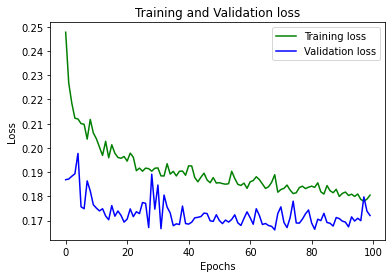

In [17]:
%matplotlib inline
NUM_EPOCHS=hyperparams['num_epochs']
plt.plot(range(0,len(train_losses)), train_losses, 'g', label='Training loss')
plt.plot(range(0,len(train_losses)), val_losses, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

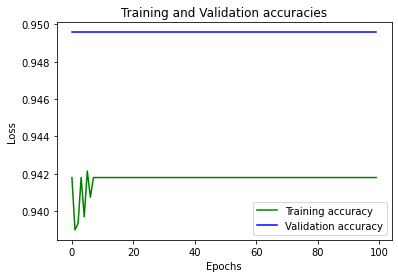

In [19]:
plt.plot(range(0,len(train_accuracies)), train_accuracies, 'g', label='Training accuracy')
plt.plot(range(0,len(train_accuracies)), val_accuracies, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracies')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

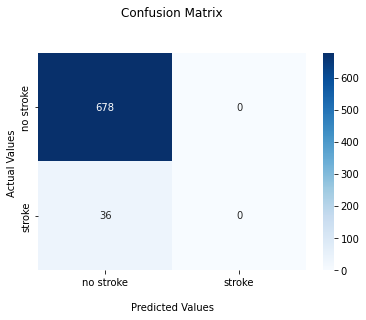

In [20]:
correct_no_stroke, wrong_no_stroke, correct_stroke, wrong_stroke= compute_confusion_matrix(
    val_predictions,
    val_labels
)
cf_matrix = [
    [correct_no_stroke, wrong_stroke],
    [wrong_no_stroke, correct_stroke]
]
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='d')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['no stroke','stroke'])
ax.yaxis.set_ticklabels(['no stroke','stroke'])
plt.show()

:We are now done with our classification task (phew!! _insert spongebob gif here_), now we do the same thing with regression. Although we are going to change some things, firstly we now wish to predict a non-binary variable, so we are no longer going to be assigning labels to our data, instead we will be predicting a scalar. Because of this, our loss function is no longer appropriate and we are going to use __MSE()__ instead. Except from this not a whole not will change, but I will comment where it has changed. But again we need to split our data appropriately and create a dataloader for our test and validation data. I will collapse this into one cell and leave it uncommented as it is nothing novel. 

In [21]:
X = data.drop(["bmi"], axis=1)
y = data["bmi"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True) #splitting data into test and train.

## turning our data into numpy arrays
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

class BMIDataset(Dataset): 

  ## A class which will return a dataset
  def __init__(self, X, y): 
    self.X = X
    self.y = y

  def __getitem__(self, index):
    
    ##concatenting the labels and features as mentioned in previous text cell
    label=self.y[index]
    features = self.X[index,:]
    sample = features, label
    return sample

  def __len__(self): 
    ##returns how many data points are in our dataset
    return len(self.y)


train_dataset=BMIDataset(X_train, y_train)
test_dataset=BMIDataset(X_test, y_test)

BATCH_SIZE=16
##Creating batches of size BATCH_SIZE for both our training and test data
train_dataloader = DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True  #shuffle the batches between each epoch [iulia] SHUFFLE!!
) 

validation_dataloader = DataLoader(
    dataset=test_dataset, 
    batch_size=BATCH_SIZE
)



**Building the model** 

Now we are going to build our model and rather boring (because I am lazy) it is going to remain unchanged (after all, why change perfection?).



In [34]:
class BMIModel(nn.Module): 

    def __init__(self, 
                 hidden_size_1: int, 
                 hidden_size_2: int,
                 hidden_size_3 :int,
                 activation_fn: Callable):
        super().__init__()
        self.hidden_size_1 = hidden_size_1
        self.hidden_size_2 = hidden_size_2
        self.hidden_size_3 = hidden_size_3    
        
        self.layer_1 = nn.Linear(in_features = 10, out_features = self.hidden_size_1, bias=True)
        self.layer_2 = nn.Linear(in_features = self.hidden_size_1, out_features = self.hidden_size_2, bias=True)
        self.layer_3 = nn.Linear(in_features = self.hidden_size_2, out_features = self.hidden_size_3, bias=True)
        self.layer_4 = nn.Linear(in_features = self.hidden_size_3, out_features = self.hidden_size_3, bias=True)
        self.layer_5 = nn.Linear(in_features = self.hidden_size_3, out_features = self.hidden_size_3, bias=True)

        self.output_layer = nn.Linear(in_features = self.hidden_size_3, out_features = 1, bias = True)    
    
        self.activation_fn = activation_fn    
    
    def forward(self, x):
        # TODO: layer1 + activation
        h1 = self.activation_fn(self.layer_1(x))
        
        # TODO: layer2 + activation
        h2 = self.activation_fn(self.layer_2(h1))        
        
        h3= self.activation_fn(self.layer_3(h2))

        h4= self.activation_fn(self.layer_3(h3))
        h5= self.activation_fn(self.layer_3(h4))
        
        # TODO: output layer
        out = self.output_layer(h5)        
        
        return out

Now we define our loss criterion

In [35]:
loss_crt = nn.MSELoss()

Now we modify our functions from earlier which helped us compute the error on training and validation set.

In [36]:
def train_reg_epoch(model, train_dataloader, loss_crt, optimizer, device): 
  model.train() 
  epoch_loss = 0.0
  num_batches = len(train_dataloader)
  predictions = [] #where we will add the predictions
  for idx, batch in tqdm(enumerate(train_dataloader)): 
    batch_features, batch_labels = batch #extract features and labels from dataloader

    batch_features = batch_features.to(device) #send our data to device
    batch_labels = batch_labels.to(device).squeeze() #likewise and squeze to transform into vector of length 16 opposed to 16x1 matrix
    
    output = model(batch_features.float()).squeeze() #run our data through our model?
    
    predictions += output.tolist() #update the lists
    
    loss= loss_crt(output.to(torch.float64), batch_labels.to(torch.float64)) #calculate error from out model
    loss_scalar = loss.item() #turn the loss output into a scaler
    loss.backward() #propogate backwards through loss function

    optimizer.step() #optimise our parameters

    model.zero_grad() #reset the gradients

    epoch_loss += loss_scalar #add it to our loss for this epoch

  train_epoch_loss = epoch_loss/num_batches #average loss over a batch in this epoch
  return train_epoch_loss, predictions


def eval_reg_epoch(model, validation_dataloader, loss_crt, device): 

  model.eval() 
  epoch_loss=0.0
  num_batches = len(validation_dataloader)
  predictions = []
  with torch.no_grad(): #we have no interest in computing gradients now
    for idx, batch in tqdm(enumerate(validation_dataloader)): #enumerates over dataloader
      batch_features, batch_labels = batch #as above

      batch_features = batch_features.to(device) #as above
      batch_labels = batch_labels.to(device).squeeze() #as above

      output = model(batch_features.float()).squeeze() #as above
      
      predictions += output.tolist() #as above
      
      loss= loss_crt(output.to(torch.float64), batch_labels.to(torch.float64)) #as above
      loss_scalar = loss.item() #as above
      epoch_loss+= loss_scalar#as above
  val_epoch_loss = epoch_loss/num_batches #as above
  return val_epoch_loss, predictions

In [ ]:
hyperparams = {
    'lr': 0.01,
    'num_epochs': 200,
    'hidden_size_1': 512,
    'hidden_size_2': 512,
    'hidden_size_3':512,
    'activation_fn': nn.ReLU(),
} #setting up our hyperparameters which we will feed in to our model and at some point hopefully optimize!
device = torch.device('cuda') 
model = BMIModel(
    hidden_size_1=hyperparams['hidden_size_1'],
    hidden_size_2=hyperparams['hidden_size_2'],
    hidden_size_3=hyperparams['hidden_size_3'],
    activation_fn=hyperparams['activation_fn']
)
model.to(device) #move our model to gpu

optimizer = torch.optim.Adam( ##We shall pick Adam as our optimiser as Iulia says it funny
    params = model.parameters(), 
    lr = hyperparams['lr'])
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 60, gamma=0.1)
                                               
train_losses, val_losses = [], []

for epoch_idx in range(hyperparams['num_epochs']):
    train_epoch_loss, train_predictions = train_reg_epoch(
        model, 
        train_dataloader, 
        loss_crt, 
        optimizer,
        device
    )
    val_epoch_loss, val_predictions = eval_reg_epoch(
        model,
        validation_dataloader,
        loss_crt,
        device
    )
    lr_scheduler.step()
    train_losses.append(train_epoch_loss)
    val_losses.append(val_epoch_loss)
    print("epoch %d, train loss=%f, val loss=%f" % (
        epoch_idx, 
        train_epoch_loss,
        val_epoch_loss
    ))

    # early stopping
    # if val_acc >= best_val_acc:
    #     best_val_acc = val_acc
    # else:
    #     break


179it [00:00, 360.92it/s]
45it [00:00, 1302.06it/s]


epoch 0, train loss=2011.761782, val loss=93.912464


179it [00:00, 373.38it/s]
45it [00:00, 1202.18it/s]


epoch 1, train loss=90.948060, val loss=96.416382


179it [00:00, 380.82it/s]
45it [00:00, 1428.53it/s]


epoch 2, train loss=73.835567, val loss=56.741884


179it [00:00, 380.51it/s]
45it [00:00, 1090.47it/s]


epoch 3, train loss=64.393192, val loss=59.032762


179it [00:00, 374.64it/s]
45it [00:00, 1259.13it/s]


epoch 4, train loss=53.182578, val loss=47.321752


179it [00:00, 367.91it/s]
45it [00:00, 1177.90it/s]


epoch 5, train loss=57.699214, val loss=58.198344


179it [00:00, 373.66it/s]
45it [00:00, 1369.22it/s]


epoch 6, train loss=56.336040, val loss=49.779255


179it [00:00, 376.93it/s]
45it [00:00, 1364.66it/s]


epoch 7, train loss=51.449469, val loss=50.909174


179it [00:00, 370.45it/s]
45it [00:00, 1318.41it/s]


epoch 8, train loss=53.933159, val loss=52.439154


179it [00:00, 371.96it/s]
45it [00:00, 1208.75it/s]


epoch 9, train loss=54.574336, val loss=57.707949


179it [00:00, 358.27it/s]
45it [00:00, 1249.28it/s]


epoch 10, train loss=51.540322, val loss=48.400930


179it [00:00, 375.33it/s]
45it [00:00, 1305.76it/s]


epoch 11, train loss=52.509522, val loss=52.559353


179it [00:00, 384.29it/s]
45it [00:00, 1357.26it/s]


epoch 12, train loss=52.245008, val loss=52.582071


179it [00:00, 362.93it/s]
45it [00:00, 1195.40it/s]


epoch 13, train loss=53.202910, val loss=57.479767


179it [00:00, 361.70it/s]
45it [00:00, 1246.99it/s]


epoch 14, train loss=52.273537, val loss=49.304308


179it [00:00, 362.52it/s]
45it [00:00, 1162.92it/s]


epoch 15, train loss=52.793155, val loss=48.563579


179it [00:00, 378.20it/s]
45it [00:00, 1036.76it/s]


epoch 16, train loss=53.539733, val loss=53.248052


179it [00:00, 360.29it/s]
45it [00:00, 1351.01it/s]


epoch 17, train loss=53.955600, val loss=49.269429


179it [00:00, 369.51it/s]
45it [00:00, 1428.39it/s]


epoch 18, train loss=53.244970, val loss=50.661041


179it [00:00, 364.93it/s]
45it [00:00, 1176.63it/s]


epoch 19, train loss=53.508343, val loss=54.317317


179it [00:00, 375.17it/s]
45it [00:00, 1347.81it/s]


epoch 20, train loss=53.288170, val loss=52.516639


179it [00:00, 373.25it/s]
45it [00:00, 1293.84it/s]


epoch 21, train loss=53.350632, val loss=50.467065


179it [00:00, 366.25it/s]
45it [00:00, 1211.15it/s]


epoch 22, train loss=53.722596, val loss=51.466149


179it [00:00, 371.60it/s]
45it [00:00, 1269.10it/s]


epoch 23, train loss=53.827531, val loss=55.081104


179it [00:00, 375.46it/s]
45it [00:00, 1240.89it/s]


epoch 24, train loss=52.826109, val loss=49.332635


179it [00:00, 377.04it/s]
45it [00:00, 1302.79it/s]


epoch 25, train loss=53.794878, val loss=54.634722


179it [00:00, 363.98it/s]
45it [00:00, 1250.39it/s]


epoch 26, train loss=54.437847, val loss=49.811698


179it [00:00, 361.38it/s]
45it [00:00, 1317.94it/s]


epoch 27, train loss=54.131339, val loss=49.247928


179it [00:00, 362.91it/s]
45it [00:00, 1329.16it/s]


epoch 28, train loss=53.139474, val loss=50.261579


179it [00:00, 371.54it/s]
45it [00:00, 1255.13it/s]


epoch 29, train loss=53.467207, val loss=51.448004


179it [00:00, 364.95it/s]
45it [00:00, 1213.22it/s]


epoch 30, train loss=52.878256, val loss=49.408929


179it [00:00, 363.67it/s]
45it [00:00, 1339.89it/s]


epoch 31, train loss=53.473975, val loss=51.066372


179it [00:00, 364.63it/s]
45it [00:00, 1266.52it/s]


epoch 32, train loss=53.950958, val loss=50.935580


179it [00:00, 369.62it/s]
45it [00:00, 1140.11it/s]


epoch 33, train loss=52.981229, val loss=49.506139


179it [00:00, 364.04it/s]
45it [00:00, 1308.29it/s]


epoch 34, train loss=52.915810, val loss=50.237142


179it [00:00, 362.81it/s]
45it [00:00, 1334.77it/s]


epoch 35, train loss=53.846613, val loss=49.430858


179it [00:00, 371.32it/s]
45it [00:00, 1216.29it/s]


epoch 36, train loss=53.409312, val loss=50.039614


179it [00:00, 372.71it/s]
45it [00:00, 1347.08it/s]


epoch 37, train loss=53.485736, val loss=53.245379


179it [00:00, 375.54it/s]
45it [00:00, 1333.21it/s]


epoch 38, train loss=54.258360, val loss=59.591327


179it [00:00, 368.20it/s]
45it [00:00, 1258.12it/s]


epoch 39, train loss=54.114785, val loss=50.170325


179it [00:00, 387.39it/s]
45it [00:00, 1252.84it/s]


epoch 40, train loss=53.268561, val loss=49.241218


179it [00:00, 383.17it/s]
45it [00:00, 1445.49it/s]


epoch 41, train loss=53.199602, val loss=49.239738


179it [00:00, 376.19it/s]
45it [00:00, 1113.56it/s]


epoch 42, train loss=52.977551, val loss=49.311620


179it [00:00, 369.41it/s]
45it [00:00, 1275.64it/s]


epoch 43, train loss=53.030321, val loss=50.307924


179it [00:00, 372.95it/s]
45it [00:00, 1148.18it/s]


epoch 44, train loss=52.710137, val loss=53.664270


179it [00:00, 364.03it/s]
45it [00:00, 1240.96it/s]


epoch 45, train loss=54.064448, val loss=49.390834


179it [00:00, 370.63it/s]
45it [00:00, 1338.32it/s]


epoch 46, train loss=52.966612, val loss=49.874100


179it [00:00, 371.95it/s]
45it [00:00, 1165.37it/s]


epoch 47, train loss=52.938464, val loss=51.011468


179it [00:00, 377.61it/s]
45it [00:00, 1372.70it/s]


epoch 48, train loss=52.535412, val loss=50.399792


179it [00:00, 379.46it/s]
45it [00:00, 1272.21it/s]


epoch 49, train loss=52.833291, val loss=49.266793


179it [00:00, 372.32it/s]
45it [00:00, 1264.47it/s]


epoch 50, train loss=53.436427, val loss=52.145254


179it [00:00, 360.88it/s]
45it [00:00, 1183.16it/s]


epoch 51, train loss=53.470754, val loss=49.343275


179it [00:00, 370.58it/s]
45it [00:00, 1012.73it/s]


epoch 52, train loss=52.211398, val loss=49.998474


179it [00:00, 367.91it/s]
45it [00:00, 1317.70it/s]


epoch 53, train loss=53.341758, val loss=51.015840


179it [00:00, 376.00it/s]
45it [00:00, 1323.14it/s]


epoch 54, train loss=53.186881, val loss=50.515197


179it [00:00, 379.68it/s]
45it [00:00, 1175.56it/s]


epoch 55, train loss=53.163481, val loss=50.596173


179it [00:00, 374.74it/s]
45it [00:00, 1101.32it/s]


epoch 56, train loss=52.876175, val loss=49.450713


179it [00:00, 377.09it/s]
45it [00:00, 1307.28it/s]


epoch 57, train loss=52.818526, val loss=54.477481


179it [00:00, 376.79it/s]
45it [00:00, 1247.90it/s]


epoch 58, train loss=52.478492, val loss=49.280535


179it [00:00, 366.85it/s]
45it [00:00, 1331.83it/s]


epoch 59, train loss=52.613835, val loss=50.272882


179it [00:00, 349.41it/s]
45it [00:00, 1138.30it/s]


epoch 60, train loss=51.925476, val loss=49.240763


179it [00:00, 361.26it/s]
45it [00:00, 1207.97it/s]


epoch 61, train loss=51.628291, val loss=49.353164


179it [00:00, 362.79it/s]
45it [00:00, 1318.84it/s]


epoch 62, train loss=51.807488, val loss=49.350761


179it [00:00, 368.46it/s]
45it [00:00, 1199.07it/s]


epoch 63, train loss=51.751993, val loss=49.511437


179it [00:00, 367.18it/s]
45it [00:00, 1311.56it/s]


epoch 64, train loss=52.230650, val loss=49.356425


179it [00:00, 361.56it/s]
45it [00:00, 1312.84it/s]


epoch 65, train loss=51.968382, val loss=49.388870


179it [00:00, 357.70it/s]
45it [00:00, 1223.01it/s]


epoch 66, train loss=51.742849, val loss=49.461163


179it [00:00, 363.49it/s]
45it [00:00, 1279.86it/s]


epoch 67, train loss=51.737239, val loss=49.241649


179it [00:00, 361.99it/s]
45it [00:00, 1347.48it/s]


epoch 68, train loss=51.706037, val loss=49.337688


179it [00:00, 356.87it/s]
45it [00:00, 1315.64it/s]


epoch 69, train loss=51.568539, val loss=49.251760


179it [00:00, 364.44it/s]
45it [00:00, 1250.09it/s]


epoch 70, train loss=51.876092, val loss=49.271307


179it [00:00, 363.30it/s]
45it [00:00, 1349.41it/s]


epoch 71, train loss=51.851227, val loss=49.242779


179it [00:00, 373.47it/s]
45it [00:00, 1294.06it/s]


epoch 72, train loss=51.882078, val loss=49.750664


179it [00:00, 366.48it/s]
45it [00:00, 1298.98it/s]


epoch 73, train loss=51.781324, val loss=49.244979


179it [00:00, 366.35it/s]
45it [00:00, 1246.01it/s]


epoch 74, train loss=51.679851, val loss=49.867825


179it [00:00, 365.97it/s]
45it [00:00, 1340.02it/s]


epoch 75, train loss=51.954201, val loss=49.591015


179it [00:00, 379.16it/s]
45it [00:00, 1261.51it/s]


epoch 76, train loss=51.842614, val loss=49.295650


179it [00:00, 356.08it/s]
45it [00:00, 1311.20it/s]


epoch 77, train loss=51.794087, val loss=49.301555


179it [00:00, 360.09it/s]
45it [00:00, 1251.70it/s]


epoch 78, train loss=51.798565, val loss=49.242225


179it [00:00, 355.33it/s]
45it [00:00, 1163.78it/s]


epoch 79, train loss=51.791253, val loss=49.240548


179it [00:00, 347.04it/s]
45it [00:00, 1190.32it/s]


epoch 80, train loss=51.621012, val loss=49.697986


179it [00:00, 361.22it/s]
45it [00:00, 1311.58it/s]


epoch 81, train loss=51.795067, val loss=49.265345


179it [00:00, 354.46it/s]
45it [00:00, 1262.28it/s]


epoch 82, train loss=51.713014, val loss=49.278111


179it [00:00, 360.55it/s]
45it [00:00, 1371.42it/s]


epoch 83, train loss=52.093984, val loss=49.307653


179it [00:00, 362.41it/s]
45it [00:00, 1211.83it/s]


epoch 84, train loss=51.872513, val loss=49.270913


179it [00:00, 381.59it/s]
45it [00:00, 1248.75it/s]


epoch 85, train loss=55.817907, val loss=49.292307


179it [00:00, 375.74it/s]
45it [00:00, 1466.61it/s]


epoch 86, train loss=51.905879, val loss=49.645614


179it [00:00, 377.60it/s]
45it [00:00, 1140.89it/s]


epoch 87, train loss=51.815789, val loss=49.280627


179it [00:00, 360.80it/s]
45it [00:00, 1330.43it/s]


epoch 88, train loss=51.834857, val loss=49.364785


179it [00:00, 385.93it/s]
45it [00:00, 1349.62it/s]


epoch 89, train loss=51.846013, val loss=49.273174


179it [00:00, 370.21it/s]
45it [00:00, 1004.78it/s]


epoch 90, train loss=51.688518, val loss=49.379755


179it [00:00, 378.91it/s]
45it [00:00, 1361.84it/s]


epoch 91, train loss=52.415796, val loss=49.267856


179it [00:00, 371.37it/s]
45it [00:00, 1383.74it/s]


epoch 92, train loss=52.021702, val loss=49.363914


179it [00:00, 382.98it/s]
45it [00:00, 1214.07it/s]


epoch 93, train loss=51.689801, val loss=49.244444


179it [00:00, 375.36it/s]
45it [00:00, 1206.64it/s]


epoch 94, train loss=51.836635, val loss=49.327001


179it [00:00, 360.35it/s]
45it [00:00, 1160.23it/s]


epoch 95, train loss=51.868916, val loss=49.240184


179it [00:00, 372.79it/s]
45it [00:00, 1245.24it/s]


epoch 96, train loss=51.690486, val loss=49.304082


179it [00:00, 376.26it/s]
45it [00:00, 1358.42it/s]


epoch 97, train loss=51.783404, val loss=49.243351


179it [00:00, 372.68it/s]
45it [00:00, 1248.87it/s]


epoch 98, train loss=51.822429, val loss=49.341880


179it [00:00, 366.32it/s]
45it [00:00, 1310.94it/s]


epoch 99, train loss=52.274243, val loss=49.629898


179it [00:00, 365.37it/s]
45it [00:00, 1391.85it/s]


epoch 100, train loss=52.213117, val loss=49.248509


179it [00:00, 356.77it/s]
45it [00:00, 1285.94it/s]


epoch 101, train loss=51.774118, val loss=49.258266


179it [00:00, 371.81it/s]
45it [00:00, 1352.59it/s]


epoch 102, train loss=51.726423, val loss=49.288108


179it [00:00, 368.52it/s]
45it [00:00, 1243.74it/s]


epoch 103, train loss=51.694014, val loss=49.306637


179it [00:00, 360.20it/s]
45it [00:00, 1269.96it/s]


epoch 104, train loss=51.922072, val loss=49.281974


179it [00:00, 359.34it/s]
45it [00:00, 1369.72it/s]


epoch 105, train loss=51.686669, val loss=49.451353


179it [00:00, 360.98it/s]
45it [00:00, 1197.69it/s]


epoch 106, train loss=51.896663, val loss=49.540623


179it [00:00, 353.54it/s]
45it [00:00, 1270.30it/s]


epoch 107, train loss=51.859123, val loss=49.271016


179it [00:00, 362.27it/s]
45it [00:00, 1163.17it/s]


epoch 108, train loss=51.759174, val loss=49.248367


179it [00:00, 372.39it/s]
45it [00:00, 1378.38it/s]


epoch 109, train loss=51.865450, val loss=49.271974


179it [00:00, 357.23it/s]
45it [00:00, 1339.61it/s]


epoch 110, train loss=51.794222, val loss=49.559544


179it [00:00, 363.74it/s]
45it [00:00, 1275.31it/s]


epoch 111, train loss=51.781201, val loss=49.239862


179it [00:00, 362.91it/s]
45it [00:00, 1383.64it/s]


epoch 112, train loss=51.768216, val loss=49.282337


179it [00:00, 368.68it/s]
45it [00:00, 1358.64it/s]


epoch 113, train loss=51.863625, val loss=49.372361


179it [00:00, 357.69it/s]
45it [00:00, 1324.98it/s]


epoch 114, train loss=51.702969, val loss=49.280883


179it [00:00, 354.34it/s]
45it [00:00, 1223.80it/s]


epoch 115, train loss=51.646008, val loss=49.274786


179it [00:00, 368.17it/s]
45it [00:00, 1358.86it/s]


epoch 116, train loss=51.941311, val loss=49.333202


179it [00:00, 365.30it/s]
45it [00:00, 1098.38it/s]


epoch 117, train loss=51.846603, val loss=49.305924


179it [00:00, 360.43it/s]
45it [00:00, 1367.22it/s]


epoch 118, train loss=52.064857, val loss=49.305993


179it [00:00, 360.54it/s]
45it [00:00, 1123.44it/s]


epoch 119, train loss=51.900592, val loss=49.630775


179it [00:00, 370.54it/s]
45it [00:00, 1322.56it/s]


epoch 120, train loss=51.719138, val loss=49.253035


179it [00:00, 366.14it/s]
45it [00:00, 1041.88it/s]


epoch 121, train loss=51.858596, val loss=49.242455


179it [00:00, 362.68it/s]
45it [00:00, 1285.36it/s]


epoch 122, train loss=51.533583, val loss=49.239941


179it [00:00, 352.53it/s]
45it [00:00, 1307.07it/s]


epoch 123, train loss=51.641570, val loss=49.240954


179it [00:00, 362.02it/s]
45it [00:00, 1284.75it/s]


epoch 124, train loss=51.570051, val loss=49.239816


179it [00:00, 359.55it/s]
45it [00:00, 1295.95it/s]


epoch 125, train loss=51.791642, val loss=49.239868


179it [00:00, 360.17it/s]
45it [00:00, 1295.95it/s]


epoch 126, train loss=51.681883, val loss=49.240668


179it [00:00, 359.70it/s]
45it [00:00, 1196.49it/s]


epoch 127, train loss=51.618477, val loss=49.241801


179it [00:00, 362.47it/s]
45it [00:00, 1229.22it/s]


epoch 128, train loss=51.698994, val loss=49.241571


179it [00:00, 370.88it/s]
45it [00:00, 1177.76it/s]


epoch 129, train loss=52.584551, val loss=49.239708


179it [00:00, 381.30it/s]
45it [00:00, 1344.02it/s]


epoch 130, train loss=51.574340, val loss=49.240582


179it [00:00, 367.35it/s]
45it [00:00, 1344.55it/s]


epoch 131, train loss=51.778808, val loss=49.239835


179it [00:00, 374.91it/s]
45it [00:00, 983.48it/s]


epoch 132, train loss=51.591348, val loss=49.240237


179it [00:00, 358.77it/s]
45it [00:00, 1284.56it/s]


epoch 133, train loss=51.896209, val loss=49.240998


179it [00:00, 363.51it/s]
45it [00:00, 1381.20it/s]


epoch 134, train loss=51.630499, val loss=49.239723


179it [00:00, 379.00it/s]
45it [00:00, 1334.88it/s]


epoch 135, train loss=51.750385, val loss=49.241301


179it [00:00, 364.40it/s]
45it [00:00, 1309.29it/s]


epoch 136, train loss=51.666995, val loss=49.240462


179it [00:00, 377.74it/s]
45it [00:00, 1375.68it/s]


epoch 137, train loss=51.564705, val loss=49.239727


179it [00:00, 366.79it/s]
45it [00:00, 1332.61it/s]


epoch 138, train loss=51.585339, val loss=49.240391


179it [00:00, 372.05it/s]
45it [00:00, 1245.87it/s]


epoch 139, train loss=51.539638, val loss=49.241471


179it [00:00, 371.56it/s]
45it [00:00, 1162.04it/s]


epoch 140, train loss=51.560704, val loss=49.246563


179it [00:00, 375.99it/s]
45it [00:00, 1291.66it/s]


epoch 141, train loss=51.628990, val loss=49.239864


179it [00:00, 359.44it/s]
45it [00:00, 1110.30it/s]


epoch 142, train loss=51.677658, val loss=49.239917


179it [00:00, 371.30it/s]
45it [00:00, 1138.10it/s]


epoch 143, train loss=51.732556, val loss=49.239800


179it [00:00, 372.56it/s]
45it [00:00, 1309.68it/s]


epoch 144, train loss=51.673429, val loss=49.239794


179it [00:00, 378.67it/s]
45it [00:00, 1449.08it/s]


epoch 145, train loss=51.793975, val loss=49.239894


179it [00:00, 370.74it/s]
45it [00:00, 1492.74it/s]


epoch 146, train loss=51.681394, val loss=49.240575


179it [00:00, 371.65it/s]
45it [00:00, 1424.66it/s]


epoch 147, train loss=51.563389, val loss=49.255196


179it [00:00, 371.68it/s]
45it [00:00, 1357.20it/s]


epoch 148, train loss=51.960881, val loss=49.240727


179it [00:00, 375.11it/s]
45it [00:00, 1080.25it/s]


epoch 149, train loss=51.592505, val loss=49.239735


179it [00:00, 368.44it/s]
45it [00:00, 1314.34it/s]


epoch 150, train loss=51.531432, val loss=49.243964


179it [00:00, 355.84it/s]
45it [00:00, 1328.26it/s]


epoch 151, train loss=51.533998, val loss=49.240487


179it [00:00, 353.42it/s]
45it [00:00, 1312.78it/s]


epoch 152, train loss=51.635006, val loss=49.240651


179it [00:00, 361.94it/s]
45it [00:00, 1270.51it/s]


epoch 153, train loss=51.618878, val loss=49.244462


179it [00:00, 359.88it/s]
45it [00:00, 1265.85it/s]


epoch 154, train loss=51.698877, val loss=49.240904


179it [00:00, 353.97it/s]
45it [00:00, 1132.49it/s]


epoch 155, train loss=51.662473, val loss=49.239760


179it [00:00, 361.31it/s]
45it [00:00, 1180.53it/s]


epoch 156, train loss=51.616018, val loss=49.239708


179it [00:00, 353.74it/s]
45it [00:00, 1018.57it/s]


epoch 157, train loss=51.707026, val loss=49.239929


179it [00:00, 365.95it/s]
45it [00:00, 1345.22it/s]


epoch 158, train loss=51.589221, val loss=49.240623


179it [00:00, 357.45it/s]
45it [00:00, 1356.44it/s]


epoch 159, train loss=51.789451, val loss=49.241654


179it [00:00, 350.84it/s]
45it [00:00, 1374.70it/s]


epoch 160, train loss=51.849714, val loss=49.239772


179it [00:00, 355.81it/s]
45it [00:00, 1366.81it/s]


epoch 161, train loss=51.782146, val loss=49.240024


179it [00:00, 365.64it/s]
45it [00:00, 1150.34it/s]


epoch 162, train loss=51.580572, val loss=49.239899


179it [00:00, 358.03it/s]
45it [00:00, 1115.71it/s]


epoch 163, train loss=51.665811, val loss=49.241708


179it [00:00, 355.67it/s]
45it [00:00, 1263.31it/s]


epoch 164, train loss=51.665272, val loss=49.239881


179it [00:00, 371.49it/s]
45it [00:00, 1296.48it/s]


epoch 165, train loss=51.666601, val loss=49.240077


179it [00:00, 361.08it/s]
45it [00:00, 1432.94it/s]


epoch 166, train loss=51.878458, val loss=49.243118


179it [00:00, 366.62it/s]
45it [00:00, 1316.42it/s]


epoch 167, train loss=51.877573, val loss=49.240865


179it [00:00, 357.20it/s]
45it [00:00, 1429.43it/s]


epoch 168, train loss=51.874811, val loss=49.240701


179it [00:00, 353.44it/s]
45it [00:00, 1252.92it/s]


epoch 169, train loss=52.145540, val loss=49.242923


179it [00:00, 357.64it/s]
45it [00:00, 1283.58it/s]


epoch 170, train loss=51.591391, val loss=49.239862


179it [00:00, 350.81it/s]
45it [00:00, 1349.56it/s]


epoch 171, train loss=51.663033, val loss=49.247459


179it [00:00, 362.22it/s]
45it [00:00, 1352.16it/s]


epoch 172, train loss=51.644207, val loss=49.249835


0it [00:00, ?it/s]

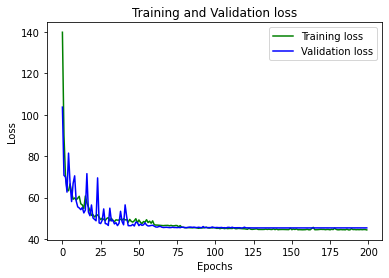

In [38]:
%matplotlib inline
NUM_EPOCHS=hyperparams['num_epochs']
plt.plot(range(0,len(train_losses)), train_losses, 'g', label='Training loss')
plt.plot(range(0,len(train_losses)), val_losses, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()